In [8]:
import sys
import os
import glob
from time import time
from collections import OrderedDict
from importlib import reload
from glob import glob

import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.stats as stats

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['xtick.labelsize'] = 'small'
mpl.rcParams['ytick.labelsize'] = 'small'
mpl.rcParams['axes.labelsize'] = 'small'
mpl.rcParams['axes.titlesize'] = 'small'
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['figure.titlesize'] = 'small'
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['lines.linewidth'] = 0.8 

import mne
import neurodsp
from ptsa.data.TimeSeriesX import TimeSeries 
import cmlreaders
from cmlreaders import CMLReader

sys.path.append('/home1/dscho/code/general')
sys.path.append('/home1/dscho/code/projects/manning_replication')
sys.path.append('/home1/dscho/code/projects/unit_activity_and_hpc_theta')
import data_io as dio
import array_operations as aop
import spectral_processing as spp
import manning_utils
import manning_analysis
import phase_locking
import lfp_synchrony
from eeg_plotting import plot_trace, plot_trace2

In [9]:
ix = CMLReader.get_data_index("r1")

In [27]:
# Load paired-associated data.
ix_pal = ix.query("(experiment=='PAL1')")
pal_subjs = ix_pal.groupby('subject').agg({'session': lambda x: list(x)})
print('{} subjs, {} sessions, {}-{} sessions/subj (median = {})'
      .format(len(pal_subjs), len(ix_pal), 
              np.min(pal_subjs['session'].apply(lambda x: len(x))),
              np.max(pal_subjs['session'].apply(lambda x: len(x))),
              np.median(pal_subjs['session'].apply(lambda x: len(x)))))

72 subjs, 151 sessions, 1-5 sessions/subj (median = 2.0)


In [27]:
pd.DataFrame(np.unique(ix.experiment, return_counts=True)).T

,0,1
0,FR1,574
1,FR2,79
2,FR3,32
3,FR5,26
4,FR6,7
5,LocationSearch,42
6,PAL1,151
7,PAL2,26
8,PAL3,15
9,PAL5,4


In [252]:
fr1_subs = list(np.unique(ix.query("(experiment == 'FR1')").subject))
catfr1_subs = list(np.unique(ix.query("(experiment == 'catFR1')").subject))
pal1_subs = list(np.unique(ix.query("(experiment == 'PAL1')").subject))
print(len(fr1_subs), len(catfr1_subs), len(pal1_subs))
alltask_subs = [sub for sub in pal1_subs if sub in [sub for sub in fr1_subs if sub in catfr1_subs]]
alltask_subs
#ix.query("experiment == {}".format(['FR1', 'catFR1', 'PAL1']))

274 206 72


['R1031M',
 'R1035M',
 'R1036M',
 'R1042M',
 'R1050M',
 'R1056M',
 'R1060M',
 'R1065J',
 'R1066P',
 'R1069M',
 'R1074M',
 'R1086M',
 'R1089P',
 'R1102P',
 'R1106M',
 'R1111M',
 'R1112M',
 'R1130M',
 'R1131M',
 'R1202M',
 'R1207J',
 'R1212P',
 'R1215M',
 'R1228M',
 'R1229M',
 'R1230J',
 'R1231M']

In [293]:
subj = 'R1231M'
expmt = 'catFR1'
#expmt = 'FR1'
sess = 0
reader = CMLReader(subj, expmt, sess)

In [294]:
pairs = reader.load("pairs")
print(pairs.shape, pairs.columns)
pairs.head()

/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1231M/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1231M/tal/R1231M_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


(91, 36) Index(['contact_1', 'contact_2', 'label', 'avg.dural.region', 'avg.dural.x',
       'avg.dural.y', 'avg.dural.z', 'avg.region', 'avg.x', 'avg.y', 'avg.z',
       'id', 'ind.dural.region', 'ind.dural.x', 'ind.dural.y', 'ind.dural.z',
       'ind.region', 'ind.x', 'ind.y', 'ind.z', 'is_explicit', 'is_stim_only',
       'stein.region', 'stein.x', 'stein.y', 'stein.z', 'tal.region', 'tal.x',
       'tal.y', 'tal.z', 'type_1', 'type_2', 'wb.region', 'wb.x', 'wb.y',
       'wb.z'],
      dtype='object')


/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/cmlreaders/readers/electrodes.py:236: MissingCoordinatesWarning: Could not load MNI coordinates
  "Could not load MNI coordinates"))


,contact_1,contact_2,label,avg.dural.region,avg.dural.x,avg.dural.y,avg.dural.z,avg.region,avg.x,avg.y,...,tal.region,tal.x,tal.y,tal.z,type_1,type_2,wb.region,wb.x,wb.y,wb.z
0,1,2,RO1-RO2,medialorbitofrontal,2.73,36.475,-16.755,medialorbitofrontal,2.73,36.475,...,None,2.626280,40.46170,-15.39680,D,D,Right MFC medial frontal cortex,NaN,NaN,NaN
1,2,3,RO2-RO3,medialorbitofrontal,5.69,36.725,-16.925,medialorbitofrontal,5.69,36.725,...,None,5.468280,40.74515,-15.55640,D,D,Right GRe gyrus rectus,NaN,NaN,NaN
2,3,4,RO3-RO4,lateralorbitofrontal,9.69,36.545,-16.775,lateralorbitofrontal,9.69,36.545,...,None,9.321175,40.65300,-15.41540,D,D,Right GRe gyrus rectus,NaN,NaN,NaN
3,4,5,RO4-RO5,lateralorbitofrontal,13.20,36.325,-16.595,lateralorbitofrontal,13.20,36.325,...,None,12.700400,40.51360,-15.24780,D,D,Right MOrG medial orbital gyrus,NaN,NaN,NaN
4,5,6,RO5-RO6,lateralorbitofrontal,16.94,36.120,-16.815,lateralorbitofrontal,16.94,36.120,...,None,16.299700,40.37725,-15.41895,D,D,Right Cerebral White Matter,NaN,NaN,NaN


In [295]:
events = reader.load('events')
start_ind = events.loc[events.type=='SESS_START'].eegoffset.iat[0]
events['sec'] = (events.eegoffset - start_ind) / eeg.samplerate
events.shape, events.columns

((1155, 27),
 Index(['eegoffset', 'answer', 'category', 'category_num', 'eegfile',
        'exp_version', 'experiment', 'intrusion', 'is_stim', 'iscorrect',
        'item_name', 'item_num', 'list', 'montage', 'msoffset', 'mstime',
        'protocol', 'recalled', 'rectime', 'serialpos', 'session', 'stim_list',
        'stim_params', 'subject', 'test', 'type', 'sec'],
       dtype='object'))

In [399]:
def f(x):
    meta_d = OrderedDict([('tools', ['OfficeSupplies', 'Tools']),
                          ('leisure', ['Toys', 'Instruments']),
                          ('animals', ['Birds', 'FarmAnimals', 'Insects', 'Zoo', 'OceanAnimals']),
                          ('vegetation', ['Flowers', 'Trees']),
                          ('body', ['Clothing', 'BodyParts']),
                          ('consumption', ['Beverages', 'Desserts', 'Fruit', 'Vegetables']),
                          ('indoors', ['Building', 'Furniture']),
                          ('outdoors', ['Landscapes', 'Weather'])])
    try:
        return phase_locking.invert_dict(meta_d)[x]
    except:
        return 'none'

words = events.loc[events.type.isin(['WORD', 'REC_WORD'])].copy()
words['meta_category'] = words.category.apply(f)
ewords = words.loc[words.type=='WORD'].copy()
rwords = words.loc[words.type=='REC_WORD'].copy()
words.shape, ewords.shape, ewords.recalled.mean(), rwords.shape, len(rwords)/len(ewords)

((428, 28), (300, 28), 0.41, (128, 28), 0.4266666666666667)

In [400]:
words.columns

Index(['eegoffset', 'answer', 'category', 'category_num', 'eegfile',
       'exp_version', 'experiment', 'intrusion', 'is_stim', 'iscorrect',
       'item_name', 'item_num', 'list', 'montage', 'msoffset', 'mstime',
       'protocol', 'recalled', 'rectime', 'serialpos', 'session', 'stim_list',
       'stim_params', 'subject', 'test', 'type', 'sec', 'meta_category'],
      dtype='object')

In [406]:
for iList in ewords.list.unique():
    print('List {}: {}'.format(iList, ewords.loc[ewords.list==iList, 'meta_category'].unique().tolist()))

List 1: ['body', 'leisure', 'animals']
List 2: ['animals', 'tools', 'consumption']
List 3: ['animals', 'body', 'consumption']
List 4: ['leisure', 'consumption', 'indoors']
List 5: ['consumption', 'leisure', 'animals']
List 6: ['indoors', 'animals']
List 7: ['outdoors', 'indoors', 'consumption']
List 8: ['consumption', 'outdoors', 'indoors']
List 9: ['vegetation', 'animals', 'leisure']
List 10: ['outdoors', 'vegetation', 'consumption']
List 11: ['none', 'consumption', 'animals']
List 12: ['indoors', 'animals', 'vegetation']
List 13: ['vegetation', 'animals', 'none']
List 14: ['body', 'outdoors', 'tools']
List 15: ['tools', 'indoors', 'consumption']
List 16: ['none', 'animals']
List 17: ['animals', 'outdoors', 'none']
List 18: ['none', 'body']
List 19: ['body', 'leisure', 'none']
List 20: ['consumption', 'vegetation', 'leisure']
List 21: ['none', 'consumption', 'outdoors']
List 22: ['none', 'animals', 'tools']
List 23: ['animals', 'vegetation', 'none']
List 24: ['none', 'consumption', 't

In [414]:
np.unique(ewords.meta_category, return_counts=True)
ewords.groupby('meta_category').agg({'item_name': [len, lambda x: len(x)/len(ewords)]})

item_name         
                    len <lambda>
meta_category                   
animals              60     0.20
body                 24     0.08
consumption          48     0.16
indoors              24     0.08
leisure              24     0.08
none                 48     0.16
outdoors             24     0.08
tools                24     0.08
vegetation           24     0.08

In [416]:
ewords.loc[ewords.meta_category=='none', 'category'].unique()

array(['Appliances', 'Vehicles', 'KitchenTools', 'Electronics'],
      dtype=object)

In [368]:
ewords.loc[ewords.category=='BodyParts', 'item_name']

45         HEAD
47         FOOT
61      FINGERS
63          EYE
136        HAND
138         ARM
144         LEG
146        NOSE
1122       KNEE
1124        EAR
1134      ELBOW
1136        TOE
Name: item_name, dtype: object

In [ ]:
# hand-held tools: officesupplies, tools (+maybe some appliances, electronics)
# leisure-related objects: toys, instruments (+maybe some electronics)
# animals: birds, farmanimals, insects, zoo, oceananimals
# vegetation: flowers, trees
# corporeal: clothing, bodyparts
# consumption: beverages, desserts, fruit, vegetables (+maybe kitchentools and some appliances/electronics)
# living spaces: building, furniture (+some appliances)
# outdoors: landscapes, weather (+maybe vehicles?)

In [299]:
np.unique(ewords.category, return_counts=True)

(array(['Appliances', 'Beverages', 'Birds', 'BodyParts', 'Building',
        'Clothing', 'Desserts', 'Electronics', 'FarmAnimals', 'Flowers',
        'Fruit', 'Furniture', 'Insects', 'Instruments', 'KitchenTools',
        'Landscapes', 'OceanAnimals', 'OfficeSupplies', 'Tools', 'Toys',
        'Trees', 'Vegetables', 'Vehicles', 'Weather', 'Zoo'], dtype=object),
 array([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12]))

In [284]:
pairs.columns

Index(['contact_1', 'contact_2', 'label', 'avg.dural.region', 'avg.dural.x',
       'avg.dural.y', 'avg.dural.z', 'avg.region', 'avg.x', 'avg.y', 'avg.z',
       'id', 'ind.dural.region', 'ind.dural.x', 'ind.dural.y', 'ind.dural.z',
       'ind.region', 'ind.x', 'ind.y', 'ind.z', 'is_explicit', 'is_stim_only',
       'stein.region', 'stein.x', 'stein.y', 'stein.z', 'tal.region', 'tal.x',
       'tal.y', 'tal.z', 'type_1', 'type_2', 'wb.region', 'wb.x', 'wb.y',
       'wb.z'],
      dtype='object')

In [283]:
np.unique(pairs['ind.region'].astype(str), return_counts=True)

(array(['None', 'bankssts', 'caudalanteriorcingulate',
        'caudalmiddlefrontal', 'inferiorparietal', 'insula',
        'lateralorbitofrontal', 'medialorbitofrontal', 'paracentral',
        'parsopercularis', 'parsorbitalis', 'postcentral',
        'posteriorcingulate', 'precentral', 'rostralanteriorcingulate',
        'superiorfrontal', 'supramarginal'], dtype=object),
 array([ 5,  1, 11, 13,  5,  2,  7,  7,  4,  7,  4,  6,  2,  4,  3,  8,  2]))

In [273]:
np.unique(events.type, return_counts=True)

(array(['COUNTDOWN_END', 'COUNTDOWN_START', 'DISTRACT_END',
        'DISTRACT_START', 'INSTRUCT_VIDEO', 'MIC_TEST', 'ORIENT',
        'ORIENT_OFF', 'PRACTICE_ORIENT', 'PRACTICE_ORIENT_OFF',
        'PRACTICE_TRIAL', 'PRACTICE_WORD', 'PRACTICE_WORD_OFF', 'PROB',
        'REC_END', 'REC_START', 'REC_WORD', 'REC_WORD_VV',
        'RETRIEVAL_ORIENT', 'SESS_END', 'SESS_START', 'START', 'STOP',
        'TRIAL', 'WORD', 'WORD_OFF'], dtype=object),
 array([ 26,  26,  26,  26,   2,   1,  25,  25,   1,   1,   1,  12,  12,
         43,  25,  25, 107,  15,  26,   1,   1,  26,  26,  25, 300, 300]))

In [259]:
cols = ['type', 'sec', 'item_name', 'category', 'list', 'serialpos', 'recalled', 'rectime', 'intrusion']
cols = ['type', 'sec', 'item_name', 'list', 'serialpos', 'recalled', 'rectime', 'intrusion']
words[cols]

,type,sec,item_name,list,serialpos,recalled,rectime,intrusion
31,WORD,292.314,ANT,1,1,1,2096,-999
32,WORD,294.814,RAT,1,2,1,3517,-999
33,WORD,297.282,PEAR,1,3,1,12308,-999
34,WORD,299.814,BRANCH,1,4,0,-999,-999
35,WORD,302.366,CAVE,1,5,0,-999,-999
36,WORD,304.748,MOLE,1,6,0,-999,-999
37,WORD,307.366,HEART,1,7,0,-999,-999
38,WORD,309.832,SLIME,1,8,0,-999,-999
39,WORD,312.432,FOOD,1,9,0,-999,-999
40,WORD,314.866,BEE,1,10,0,-999,-999


In [242]:
np.unique(events.loc[events.type=='WORD'][['category', 'item_name']].category, return_counts=True)

(array(['Appliances', 'Beverages', 'Birds', 'BodyParts', 'Building',
        'Clothing', 'Desserts', 'Electronics', 'FarmAnimals', 'Flowers',
        'Fruit', 'Furniture', 'Insects', 'Instruments', 'KitchenTools',
        'Landscapes', 'OceanAnimals', 'OfficeSupplies', 'Tools', 'Toys',
        'Trees', 'Vegetables', 'Vehicles', 'Weather', 'Zoo'], dtype=object),
 array([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12]))

In [ ]:
'/data/eeg/R1231M/eeg.noreref/R1231M_FR1_0_10Oct16_1939'

In [291]:
# /ram
events.eegfile

0       R1231M_FR1_0_10Oct16_1939
1       R1231M_FR1_0_10Oct16_1939
2       R1231M_FR1_0_10Oct16_1939
3       R1231M_FR1_0_10Oct16_1939
4       R1231M_FR1_0_10Oct16_1939
5       R1231M_FR1_0_10Oct16_1939
6       R1231M_FR1_0_10Oct16_1939
7       R1231M_FR1_0_10Oct16_1939
8       R1231M_FR1_0_10Oct16_1939
9       R1231M_FR1_0_10Oct16_1939
10      R1231M_FR1_0_10Oct16_1939
11      R1231M_FR1_0_10Oct16_1939
12      R1231M_FR1_0_10Oct16_1939
13      R1231M_FR1_0_10Oct16_1939
14      R1231M_FR1_0_10Oct16_1939
15      R1231M_FR1_0_10Oct16_1939
16      R1231M_FR1_0_10Oct16_1939
17      R1231M_FR1_0_10Oct16_1939
18      R1231M_FR1_0_10Oct16_1939
19      R1231M_FR1_0_10Oct16_1939
20      R1231M_FR1_0_10Oct16_1939
21      R1231M_FR1_0_10Oct16_1939
22      R1231M_FR1_0_10Oct16_1939
23      R1231M_FR1_0_10Oct16_1939
24      R1231M_FR1_0_10Oct16_1939
25      R1231M_FR1_0_10Oct16_1939
26      R1231M_FR1_0_10Oct16_1939
27      R1231M_FR1_0_10Oct16_1939
28      R1231M_FR1_0_10Oct16_1939
29      R1231M

In [145]:
eeg = reader.load_eeg(events=words, rel_start=100, rel_stop=500, scheme=pairs)

/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1024E/experiments/catFR2/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1024E/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


In [146]:
# epochs x channels x time
eeg.data.shape, eeg.samplerate, len(eeg.epochs)

((300, 163, 200), 500, 300)

(<Figure size 3600x1200 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2b0c7b238518>],
       dtype=object))

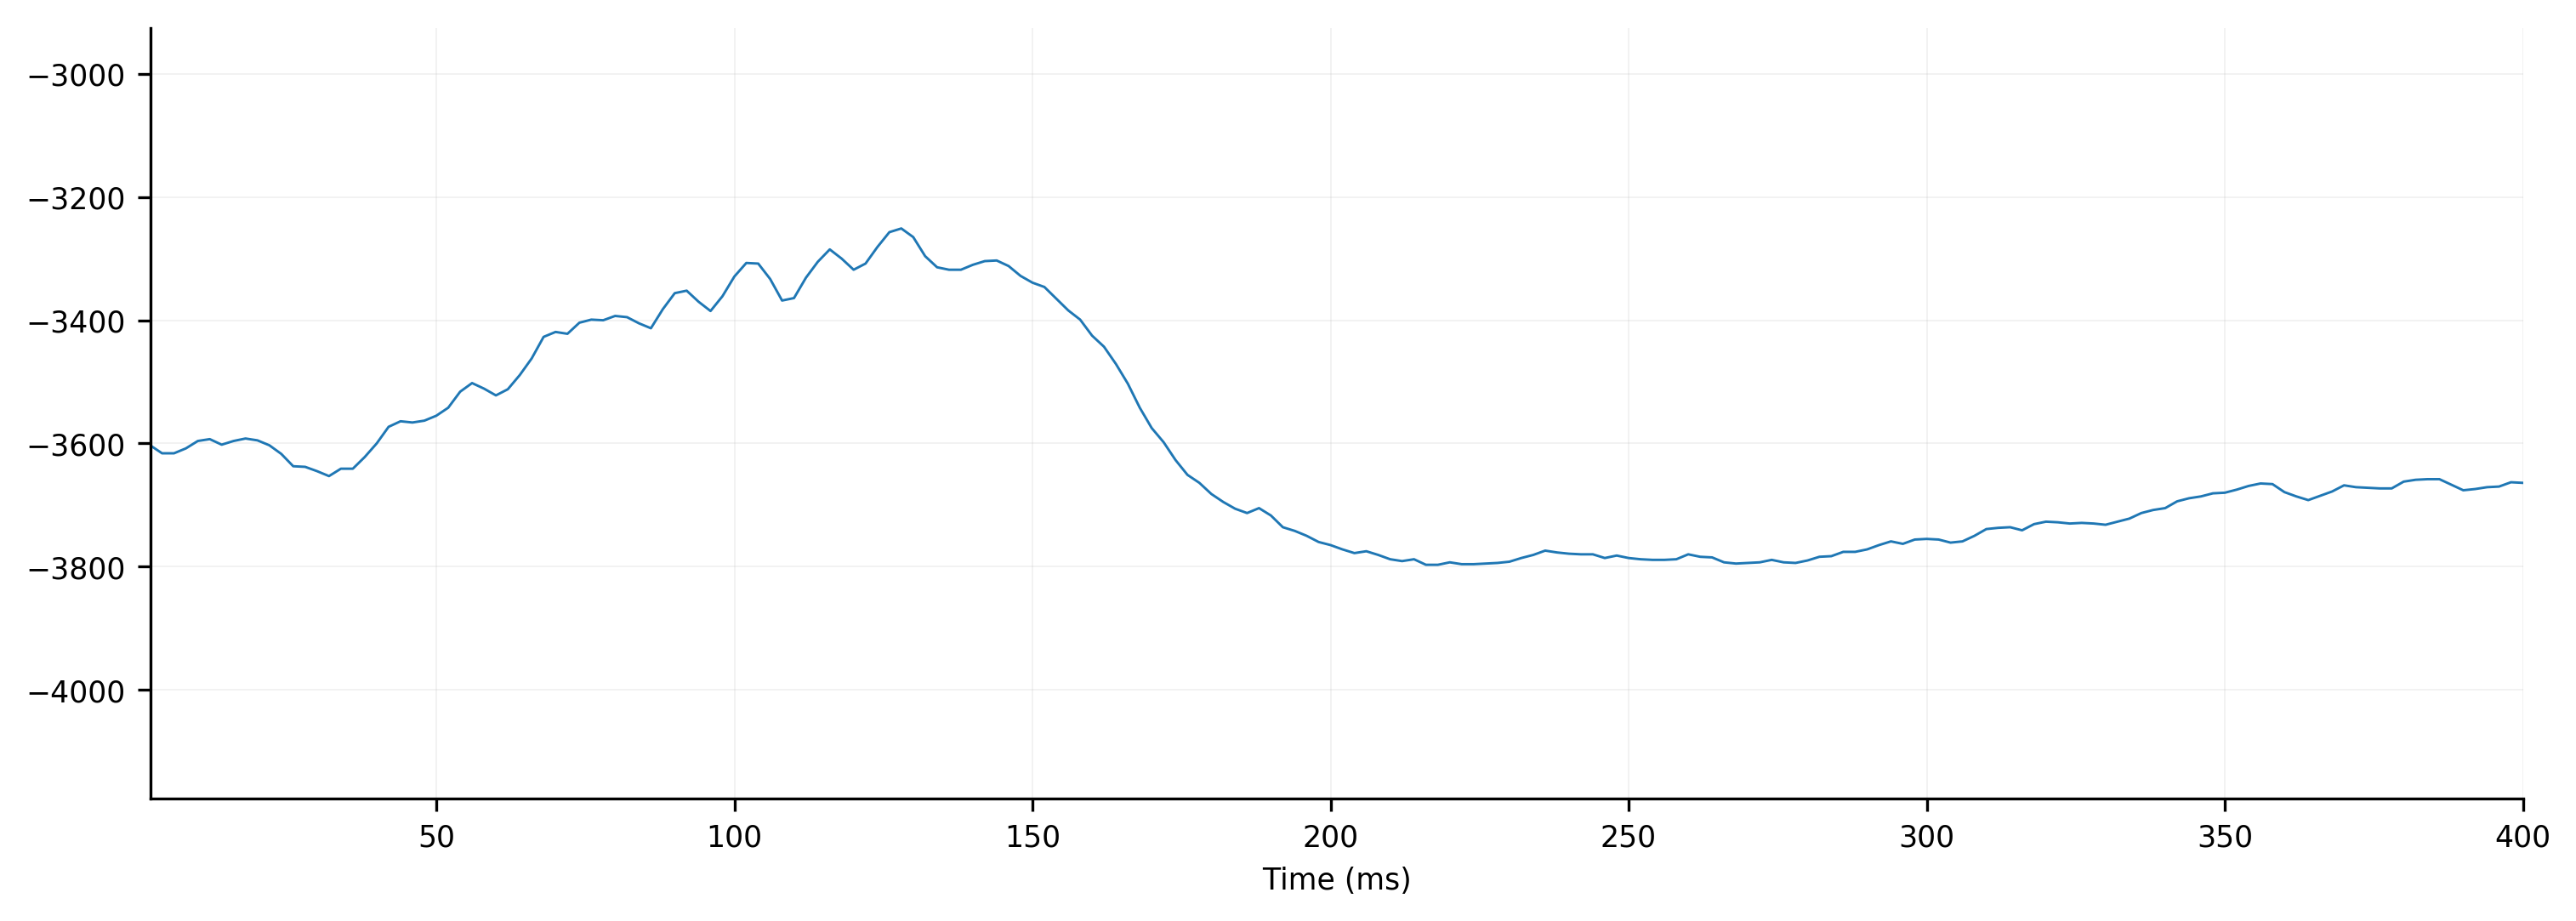

In [150]:
plot_trace(eeg.data[10, 100:101, :], x_units='ms', sampling_rate=eeg.samplerate)

In [138]:
events[events.is_stim==1].stim_params.iat[0]

{'amplitude': 1000.0,
 'anode_label': 'LMH1',
 'anode_number': 12,
 'burst_freq': 1,
 'cathode_label': 'LMH2',
 'cathode_number': 13,
 'n_bursts': 1,
 'n_pulses': 250,
 'pulse_freq': 50,
 'pulse_width': 300,
 'stim_duration': 4600,
 'stim_on': 1}

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8), dpi=300)
ax = np.ravel(ax)

tickfontsize = 8
labelfontsize = 10
figfontsize = 14

# Plot 1
df = pd.DataFrame([('No stim.', 40),
                   ('Encoding stim.', 30),
                   ('Retrieval stim.', 30)],
                  columns=['task', 'mem'])
sns.barplot(x='task', y='mem', data=df, color='k', saturation=100, ax=ax[0])
ax[0].set_ylim([25, 45])
ax[0].set_yticks([30, 35, 40, 45])
ax[0].set_xticklabels(['None', 'Encoding', 'Retrieval'], fontsize=tickfontsize)
ax[0].set_xlabel('Stim type', fontsize=labelfontsize, labelpad=5)
ax[0].set_ylabel('Word pairs recalled (%)', fontsize=labelfontsize, labelpad=5)